Loaded


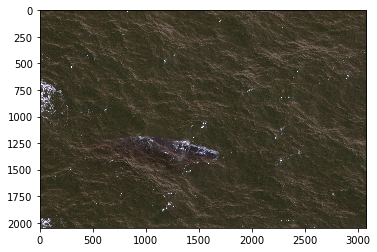

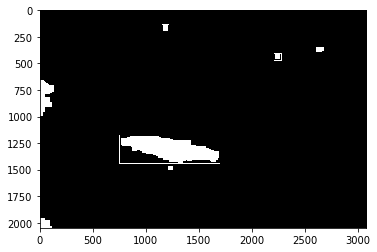

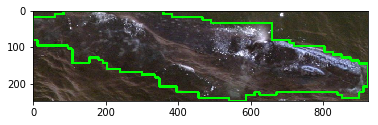

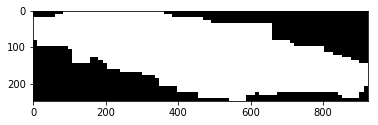

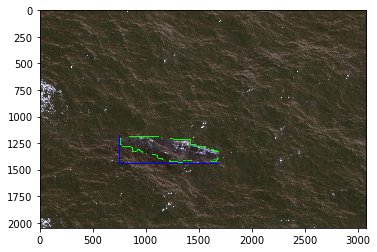

In [25]:
%matplotlib inline
#Finding whales for Kaggle's NOAA Right Whale Recognition Challenge
#   https://www.kaggle.com/c/noaa-right-whale-recognition

import sys
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt

#Get the histogram. All histograms must be the same kind
def getHist(im):
    hist = cv2.calcHist([im],[0,1,2],None,[16,16,16],[0,255,0,255,0,255])
    return(hist)

#Divide the image in four subimages
def divImage(im):
    height,width,channels = im.shape
    im1 = im[0:int(height/2), 0:int(width/2)]
    im2 = im[0:int(height/2), int(width/2):width]
    im3 = im[int(height/2):height, 0:int(width/2)]
    im4 = im[int(height/2):height, int(width/2):width]
    return([im1,im2,im3,im4])

#Sets a whole image to a value. By default, black
def setImage(im,val=0):
    for i in range(0,3):
        im[:,:,i]=val

#Create a mask image to select regions with a distinct histogram. 
#  white zones are different enough from the base image
#  im: image
#  baseHist: Histogram of the base image (currently, the original image)
#  label: A label for the current step, just for debug 
def simHist(im, baseHist, label=""):
    #print label
    height,width,channels = im.shape
    if width < 10 or height < 10:
        setImage(im,0)
        return
    images = divImage(im)
    histg = baseHist
    #Test: this compares each subimage with the current image's histogram instead of the base (whole image)
    #histg = getHist(im)
    # CORREL: Other similarity measures may be tested
    sim = [cv2.compareHist(histg, getHist(imx), cv2.HISTCMP_CORREL) for imx in images]

    for i in range(0,len(sim)):
        #This is the threshold to consider too different 
        if sim[i] < 0.25:
            setImage( images[i], 255 )
        else:
            sim.append( simHist( images[i], histg, label+str(i) ) )

    return(sim)

#Show a image, somewhat adjusted to fit screen
def show(name,imx):
    #height,width,channels = imx.shape
    #orgfx = 600.0 / width
    #imx = cv2.resize(imx,None,fx=orgfx,fy=orgfx,interpolation=cv2.INTER_CUBIC)
    #cv2.imshow(name,imx)
    plt.imshow(imx)
    plt.show()

#CLAHE as suggested by @dietCoke
def clahe(rgb):
    claheizer = cv2.createCLAHE()
    lab = cv2.cvtColor(rgb.astype('uint8'), cv2.COLOR_RGB2Lab)
    lab[:,:,0] = claheizer.apply(lab[:,:,0])
    rgb = cv2.cvtColor(lab.astype('uint8'), cv2.COLOR_Lab2RGB)
    return rgb

#MAIN
#fpath = sys.argv[1]
fpath = "/projects/github/whale_detector/w_7489.jpg"
im = cv2.imread(fpath)
if im is None:
    print('Failed to load image file:', fname)
    sys.exit(1)

print("Loaded")
org = im

#SHOW ORIGINAL
show("org",org)

%matplotlib inline
#PREPROCESS
#   Convert to HSV, yields better results than BGR
im = cv2.cvtColor(im,cv2.COLOR_BGR2HSV)
#   Testing if CLAHE improves result
#im = clahe(im)
#   get original image hist
baseHist = getHist(im)

#PROCESS
#   Perform region selection by histogram similarity. Returns a mask on whole image
res = simHist(im,baseHist)

#POST
#  Clean blobs detected
kernel = np.ones((40,40),np.uint8)
im = cv2.erode(im,kernel,iterations=1)
im = cv2.dilate(im,kernel,iterations=1)

#   Mark regions
im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(im,127,255,0)
_,contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
best = None
best_size = 0
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    size = w * h
    if size > best_size:
        best_size = size
        best = cnt
    cv2.rectangle(im,(x-10,y-10),(x+w+10,y+h+10),(255,255,255),2)

#Select biggest contour, assume that's the whale :D
#  shows boundng box and contour
if best_size > 0:
    bx,by,bw,bh = cv2.boundingRect(best)
    extract = org[ by:(by+bh), bx:(bx+bw) ]
    mask = im[ by:(by+bh), bx:(bx+bw) ]

    #save extract and mask
    cv2.imwrite(fpath+".extract.jpg",extract)
    cv2.imwrite(fpath+".mask.jpg",mask)

    #show findings
    cv2.rectangle(org,(bx-10,by-10),(bx+bw+10,by+bh+10),(0,0,255),5)
    cv2.drawContours(org,[best],0,(0,255,0),5)
    im = cv2.cvtColor(im,cv2.COLOR_GRAY2BGR)
    show("full mask",im)
    show("extract",extract)
    mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
    show("extract mask",mask)
    show("areas",org)

    cv2.imwrite(fpath+".mask-areas.jpg",im)
    cv2.imwrite(fpath+".areas.jpg",org)


#cv2.waitKey(45000)